# シュレッダー復元問題の定式化

## ネットワーク定式化

### 定数とインデックス

- $R$: 縦方向の分割数
- $C$: 横方向の分割数
- $N$: 紙片の総数, $R \times C$
- $S^{x}_{ab}$: 紙片 $a$ の右に紙片 $b$ が置かれている場合の類似度
- $S^{y}_{ab}$: 紙片 $a$ の下に紙片 $b$ が置かれている場合の類似度
- $a,b \in [1,\dots,N]$: 紙片を表すインデックス

### 変数

- $x_{ab}$: 紙片 $a$ の右に紙片 $b$ が置かれている場合は $1$ となるフラグ
- $y_{ab}$: 紙片 $a$ の下に紙片 $b$ が置かれている場合は $1$ となるフラグ
- $u^{x}_{a}$: 横方向のポテンシャル
- $u^{y}_{a}$: 縦方向のポテンシャル

### 目的関数

$$
\max \sum_{ab}S^{x}_{ab}x_{ab} + \sum_{ab}S^{y}_{ab}x_{ab}
$$

### 制約条件

- $\sum_{b} x_{ab} = 1$
- $\sum_{b} x_{ba} = 1$
- $\sum_{b} y_{ab} = 1$
- $\sum_{b} y_{ba} = 1$
- $u^{x}_{a} + 1 - (N-1)(1 - x_{ab}) \leq u^{x}_{b}$
- $u^{y}_{a} + 1 - (N-1)(1 - y_{ab}) \leq u^{y}_{b}$
- $u^{x}_{a} - (N-1)(1 - y_{ab}) \leq u^{x}_{b}$
- $u^{y}_{a} - (N-1)(1 - x_{ab}) \leq u^{y}_{b}$



In [1]:
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pulp

In [250]:
def load_data(path):
    with open(path, 'rb') as i_:
        return pickle.load(i_)

data = load_data('../data/shred/depositphotos_11056146-stock-photo-two-peeking-from-hole-in_2_30.pkl')

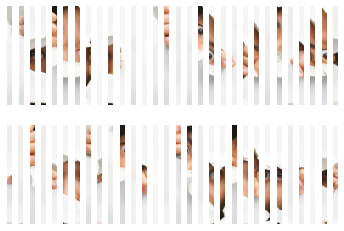

In [251]:
def show(images, rows, cols):
    fig = plt.figure()
    for i, image in enumerate(images):
        ax = fig.add_subplot(rows, cols, i + 1)
        ax.axis('off')
        ax.imshow(image)
    fig.show()

show(data.images, data.rows, data.cols)

In [252]:
def sim_x(left, right):
    shape = np.min((left.shape, right.shape), axis=0)
    return (left[:shape[0], -1] == right[:shape[0], 0]).sum()

def sim_y(up, down):
    shape = np.min((up.shape, down.shape), axis=0)
    return (up[-1, :shape[1]] == down[0, :shape[1]]).sum()

print(sim_x(data.images[0], data.images[1]))
print(sim_y(data.images[0], data.images[1]))

357
0


In [253]:
def build_model(data):
    model = pulp.LpProblem(sense=pulp.LpMaximize)
    x = np.array(pulp.LpVariable.matrix(
        'x',
        (range(data.size + 1), range(data.size + 1)),
        cat=pulp.LpBinary
    ))
    y = np.array(pulp.LpVariable.matrix(
        'y',
        (range(data.size + 1), range(data.size + 1)),
        cat=pulp.LpBinary
    ))
    ux = np.array(pulp.LpVariable.matrix(
        'ux',
        (range(data.size),),
        lowBound=1.0,
        upBound=data.cols,
        cat=pulp.LpContinuous
    ))
    uy = np.array(pulp.LpVariable.matrix(
        'uy',
        (range(data.size),),
        lowBound=1.0,
        upBound=data.rows,
        cat=pulp.LpContinuous
    ))

    model.setObjective(pulp.lpSum(
            sim_x(data.images[a], data.images[b])*x[a, b]
            for a in range(data.size)
            for b in range(data.size)
            if a != b
        ) + pulp.lpSum(
            sim_y(data.images[a], data.images[b])*y[a, b]
            for a in range(data.size)
            for b in range(data.size)
            if a != b
        )
    )

    for a in range(data.size):
        model.addConstraint(pulp.lpSum(x[a]) - x[a, a] == 1)
        model.addConstraint(pulp.lpSum(x[:, a]) - x[a, a] == 1)
        model.addConstraint(pulp.lpSum(y[a]) - y[a, a] == 1)
        model.addConstraint(pulp.lpSum(y[:, a]) - y[a, a] == 1)
    model.addConstraint(pulp.lpSum(x[-1]) - x[-1, -1] <= data.rows)
    model.addConstraint(pulp.lpSum(x[:-1, -1]) == data.rows)
    model.addConstraint(pulp.lpSum(y[-1]) - y[-1, -1] == data.cols)
    model.addConstraint(pulp.lpSum(y[:, -1]) - y[-1, -1] == data.cols)


    for a in range(data.size):
        for b in range(data.size):
            if a != b:
                model.addConstraint(
                    ux[a] + 1 - data.cols*(1 - x[a, b]) <= ux[b]
                )
                model.addConstraint(
                    ux[a] - data.cols*(1 - y[a, b]) <= ux[b]
                )
                model.addConstraint(
                    uy[a] + 1 - data.rows*(1 - y[a, b]) <= uy[b]
                )
                model.addConstraint(
                    uy[a] - data.rows*(1 - x[a, b]) <= uy[b]
                )
    return model, x, y, ux, uy

model, x, y, ux, uy = build_model(data)

In [254]:
solver = pulp.PULP_CBC_CMD(timeLimit=5*60*4, threads=4)

%time model.solve(solver)

CPU times: user 535 ms, sys: 37.9 ms, total: 573 ms
Wall time: 7min 27s


1

25293.0


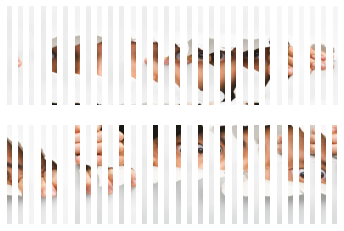

In [255]:
values = np.vectorize(lambda x: x.value())

pos = values([uy - 1, ux]).T.tolist()
show(
    [data.images[_] for _ in sorted(range(data.size), key=lambda x: pos[x])],
    data.rows,
    data.cols
)
print(model.objective.value())

In [260]:
np.array(np.where(values(x) == 1)).T

array([[ 0,  1],
       [ 1, 37],
       [ 2,  8],
       [ 3,  9],
       [ 4, 50],
       [ 5,  6],
       [ 6, 28],
       [ 7, 21],
       [ 8, 57],
       [ 9, 35],
       [10, 12],
       [11, 16],
       [12, 43],
       [13,  0],
       [14, 32],
       [15, 47],
       [16, 39],
       [17, 46],
       [18, 60],
       [19, 23],
       [20, 41],
       [21, 59],
       [22, 52],
       [23, 11],
       [24,  5],
       [25, 30],
       [26, 42],
       [27, 22],
       [28, 18],
       [29, 58],
       [30, 38],
       [31, 25],
       [32,  4],
       [33, 44],
       [34, 10],
       [35, 51],
       [36, 48],
       [37, 45],
       [38, 29],
       [39, 13],
       [40, 17],
       [41,  3],
       [42, 56],
       [43, 14],
       [44, 55],
       [45, 60],
       [46, 24],
       [47, 33],
       [48, 54],
       [49,  7],
       [50, 40],
       [51, 36],
       [52, 26],
       [53, 49],
       [54, 53],
       [55, 31],
       [56, 19],
       [57, 27],
       [58,  2

In [256]:
_ = values(x)
for a in range(data.size):
    print(f'{a} --[right]--> {_[a].argmax()}')

_ = values(y)
for a in range(data.size):
    print(f'{a} --[down]--> {_[a].argmax()}')

0 --[right]--> 1
1 --[right]--> 37
2 --[right]--> 8
3 --[right]--> 9
4 --[right]--> 50
5 --[right]--> 6
6 --[right]--> 28
7 --[right]--> 21
8 --[right]--> 57
9 --[right]--> 35
10 --[right]--> 12
11 --[right]--> 16
12 --[right]--> 43
13 --[right]--> 0
14 --[right]--> 32
15 --[right]--> 47
16 --[right]--> 39
17 --[right]--> 46
18 --[right]--> 60
19 --[right]--> 23
20 --[right]--> 41
21 --[right]--> 59
22 --[right]--> 52
23 --[right]--> 11
24 --[right]--> 5
25 --[right]--> 30
26 --[right]--> 42
27 --[right]--> 22
28 --[right]--> 18
29 --[right]--> 58
30 --[right]--> 38
31 --[right]--> 25
32 --[right]--> 4
33 --[right]--> 44
34 --[right]--> 10
35 --[right]--> 51
36 --[right]--> 48
37 --[right]--> 45
38 --[right]--> 29
39 --[right]--> 13
40 --[right]--> 17
41 --[right]--> 3
42 --[right]--> 56
43 --[right]--> 14
44 --[right]--> 55
45 --[right]--> 60
46 --[right]--> 24
47 --[right]--> 33
48 --[right]--> 54
49 --[right]--> 7
50 --[right]--> 40
51 --[right]--> 36
52 --[right]--> 26
53 --[right]

In [266]:
for i in range(data.rows):
    print(f'row: {i}')
    print(values(ux)[values(uy) == i + 1])

row: 0
[12.  3. 12. 13.  4. 16.  1.  1. 13.  7. 10.  8.  6.  3. 15.  5.  7.  9.
  2.  4.  2.  8. 11.  6. 10.  9.  5. 14. 11. 14.]
row: 1
[27. 28. 21. 27. 28. 23. 17. 26. 19. 24. 24. 30. 21. 16. 22. 26. 18. 15.
 29. 20. 29. 25. 23. 19. 18. 30. 25. 22. 17. 20.]
